In [1]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

#Set the seed for reproducibility
np.random.seed(7)
random.seed(7)

In [2]:
def add_features(df):
    df['month'] = df['PRICES'].dt.month - 1
    df['day'] = df['PRICES'].dt.day - 1
    df['year'] = df['PRICES'].dt.year
    df['day_of_week'] = df['PRICES'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'].astype(int)
    df = df.drop(columns=["PRICES"])
    return df

train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
val = pd.read_excel("validate.xlsx", parse_dates=['PRICES'])
train = add_features(train)
val = add_features(val)
train.head()

,Hour 01,Hour 02,Hour 03,Hour 04,Hour 05,Hour 06,Hour 07,Hour 08,Hour 09,Hour 10,...,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24,month,day,year,day_of_week
0,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,6.31,...,37.99,33.11,37.99,33.00,36.48,30.65,0,0,2007,0
1,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,39.60,...,59.69,50.09,50.00,36.22,31.09,29.84,0,1,2007,1
2,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,49.09,...,60.99,55.51,51.77,34.51,39.31,38.05,0,2,2007,2
3,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,42.03,...,58.99,53.50,44.01,35.00,34.46,31.57,0,3,2007,3
4,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,45.00,...,53.00,45.91,36.74,29.61,30.61,27.51,0,4,2007,4


In [3]:
class SmartGridEnv(gym.Env):
    def __init__(self, price_data, battery_capacity=50, max_power=25, efficiency=0.9, mode='training'):
        super(SmartGridEnv, self).__init__()
        self.mode = mode
        self.price_data = price_data
        self.battery_capacity = battery_capacity
        self.max_power = max_power
        self.efficiency = efficiency
        self.action_space = gym.spaces.Discrete(51, start=-25)
        self.time_constraint = 6
        self.battery_time_constraint = 20
        self.initialize_params()

    def initialize_params(self):
        self.available = True
        self.current_step = 0
        self.current_month = 0
        self.current_day = 0
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        self.current_hour = 0
        self.current_battery = 20
        self.low_battery = int(self.current_battery < 20)
        
        self.current_state = tuple([self.current_hour, self.low_battery])
        self.state_space = [24, 2, self.action_space.n]
        
        self.done = False
        self.profit = 0 

    def car_available(self):
        if self.current_hour == 7:
            available = np.random.uniform(0, 1) < 0.5 
        else:
            available = True
        return available

    def update_state(self):
        # If the car is not available, it returns at 6pm with 20kW less
        if self.available == False:
            #print('Car unavailable')
            self.current_hour = 18
            self.current_battery -= 20
        else:
            self.current_hour = int((self.current_hour + 1) % 24)
            if self.current_hour == 0:
                self.current_step += 1
       
        self.current_month = int(self.price_data.iloc[self.current_step]['month'])
        self.current_day = int(self.price_data.iloc[self.current_step]['day'])
        self.low_battery = int(self.current_battery < 20)
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
    
        # Update state
        self.current_state = self.current_state = tuple([self.current_hour, self.low_battery])

        # Check if the episode is done (after 3 years of past electricity prices)
        if self.current_step >= len(self.price_data) - 1:
            self.done = True

    def to_discrete(self, action):
        mask = np.zeros(self.action_space.n, dtype=np.int8)
        mask[action] = 1
        return self.action_space.sample(mask = mask)
        
    def step(self, action):
        if self.mode == 'training':
            self.available = self.car_available()
        
        # discretize action
        if self.available == True:
             action = self.to_discrete(action)  #this resamples instead of calling on car_available
        else:
             action = 0
    
        # charge cost
        energy_rate = self.price_data.iloc[self.current_step, self.current_hour]
        charge_cost = action if action < 0 else action * 2
        charge_cost *= energy_rate / 1000

        # update battery
        actual_charge = np.round(self.efficiency * action).astype(int) #should  be divided by 0.9 if we're selling
        self.current_battery += actual_charge

        # reward shaping
        reward = -charge_cost #+ (action > 0 and self.current_hour > 12) * 0.05
        
        # update variables
        self.profit += -charge_cost
        self.update_state()
        
        return self.current_state, reward, self.done


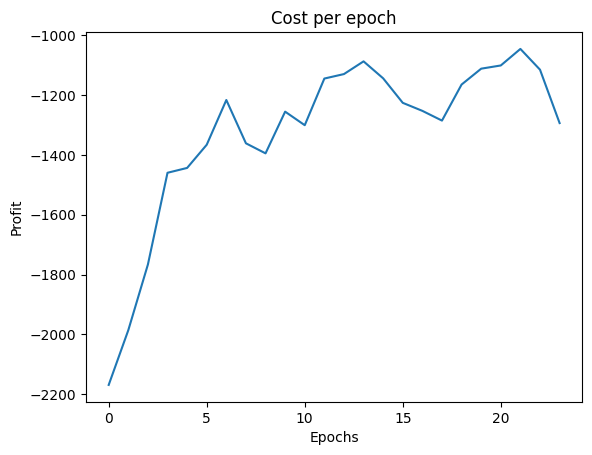

In [6]:
class QAgent():
    def __init__(self, env, discount_rate = 0.95, learning_rate=0.1, epsilon=0.05):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Qtable = np.zeros(env.state_space)
        self.profit = []

    def mask(self):
        # 8 am constraint
        if self.env.current_hour == self.env.time_constraint:
            lower_bound = self.env.battery_time_constraint - self.env.current_battery
            upper_bound =  min(self.env.max_power, self.env.battery_capacity - self.env.current_battery)
            mask_range = (lower_bound, upper_bound)
                        
        else:
            lower_bound = -min(self.env.current_battery, self.env.max_power)
            upper_bound = min(self.env.battery_capacity - self.env.current_battery, self.env.max_power)
            mask_range = (lower_bound, upper_bound)

        # constrct boolean mask_vector
        mask = np.arange(self.env.action_space.start, self.env.action_space.start + self.env.action_space.n)
        mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False)
        return mask

    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()

        # pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            action = np.random.choice(np.arange(env.action_space.n)[mask])
        
        # pick greedy action
        else:
            max_action = np.argmax(self.Qtable[current_state][mask])
            action = np.where(mask)[0][0] + max_action

        return action

    def train(self, simulations = 100, epsilon = 0.05):
        for i in range(simulations):
            while not self.env.done:
                current_state = tuple(self.env.current_state)
                action = self.select_action_epsilon_greedy(current_state)
                next_state, reward, done = env.step(action)
                next_state_mask = self.mask()
                
                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] += delta

            self.profit.append(env.profit)
            self.env.initialize_params()

    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(self.Qtable[state][mask])
        action = np.where(mask)[0][0] + max_action
        return action

    def plot_profits(self):
        plt.plot(agent.profit)
        plt.xlabel('Epochs')  
        plt.ylabel('Profit')
        plt.title("Cost per epoch") 

env = SmartGridEnv(train)
agent = QAgent(env)
agent.train(simulations=24)
agent.plot_profits()

## Eval

In [7]:
eval_env = SmartGridEnv(val, mode='eval')
agent.env = eval_env

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action = agent.predict(current_state)
    next_state, reward, done = agent.env.step(action)
    # print(f"at {agent.env.current_hour} purchase/sell {action} for {reward}")

print("Profit on validation set: ", eval_env.profit)

Profit on validation set:  -214.63006000000013
